En este notebook trabajé con información publicada por el BCRP en su portal de estadísticas. Utilicé la serie temporal del Índice de Precios al Consumidor (IPC) para Lima Metropolitana, con base diciembre 2021 = 100, como variable principal para modelar dinámicas inflacionarias mediante ARMA o ARIMA, según las condiciones de estacionariedad.
Además, incorporé otras variables macroeconómicas relevantes — tasa de referencia, tipo de cambio interbancario, y expectativas de inflación — con el objetivo de construir un modelo SARIMAX, que permite incluir variables exógenas y capturar mejor la interacción entre precios y fundamentos económicos.


In [86]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.simplefilter("ignore")

In [13]:
df = pd.read_csv('ipc.18_25.csv')
df.head()
df.columns

Index(['Fecha',
       'Índice de precios Lima Metropolitana (índice Dic.2021 = 100) - Índice de Precios al Consumidor (IPC)',
       'Índice de precios Lima Metropolitana (índice Dic.2021 = 100) - IPC Alimentos y Energía',
       'Índice de precios Lima Metropolitana (índice Dic.2021 = 100) - IPC Sin Alimentos y Bebidas',
       'Índice de precios Lima Metropolitana (índice Dic.2021 = 100) - IPC Sin Alimentos y Energía',
       'Tasas de interés del Banco Central de Reserva - Tasa de Referencia de la Política Monetaria',
       'Tipo de cambio - promedio del periodo (S/ por US$) - Interbancario - Promedio',
       'Expectativas macroeconómicas - Expectativa de Inflación a 12 meses'],
      dtype='object')

In [14]:
#necesito convertir la columna 1 a ipc mensual para poder trabajar con los modelos de series de tiempo

df["IPC"]= df['Índice de precios Lima Metropolitana (índice Dic.2021 = 100) - Índice de Precios al Consumidor (IPC)'].pct_change()*100

In [17]:
#Reconfiguro el orden de las columnas por comodidad, paso presindible
df = df[['Fecha',
       'IPC',
       'Índice de precios Lima Metropolitana (índice Dic.2021 = 100) - Índice de Precios al Consumidor (IPC)',
       'Índice de precios Lima Metropolitana (índice Dic.2021 = 100) - IPC Alimentos y Energía',
       'Índice de precios Lima Metropolitana (índice Dic.2021 = 100) - IPC Sin Alimentos y Bebidas',
       'Índice de precios Lima Metropolitana (índice Dic.2021 = 100) - IPC Sin Alimentos y Energía',
       'Tasas de interés del Banco Central de Reserva - Tasa de Referencia de la Política Monetaria',
       'Tipo de cambio - promedio del periodo (S/ por US$) - Interbancario - Promedio',
       'Expectativas macroeconómicas - Expectativa de Inflación a 12 meses']]

In [18]:
df

,Fecha,IPC,Índice de precios Lima Metropolitana (índice Dic.2021 = 100) - Índice de Precios al Consumidor (IPC),Índice de precios Lima Metropolitana (índice Dic.2021 = 100) - IPC Alimentos y Energía,Índice de precios Lima Metropolitana (índice Dic.2021 = 100) - IPC Sin Alimentos y Bebidas,Índice de precios Lima Metropolitana (índice Dic.2021 = 100) - IPC Sin Alimentos y Energía,Tasas de interés del Banco Central de Reserva - Tasa de Referencia de la Política Monetaria,Tipo de cambio - promedio del periodo (S/ por US$) - Interbancario - Promedio,Expectativas macroeconómicas - Expectativa de Inflación a 12 meses
0,2018-12-01,NaN,90.421894,87.534374,90.912793,93.042978,2.75,3.364384,2.500000
1,2019-01-01,0.065332,90.480968,87.602860,91.053589,93.093510,2.75,3.343814,2.477083
2,2019-02-01,0.126761,90.595663,87.715414,91.215150,93.209849,2.75,3.321600,2.400000
3,2019-03-01,0.727552,91.254794,88.052681,92.057228,94.161444,2.75,3.304319,2.330000
4,2019-04-01,0.200081,91.437377,88.391995,92.151483,94.201758,2.75,3.303405,2.380000
...,...,...,...,...,...,...,...,...,...
74,2025-02-01,0.188012,114.279991,117.694031,110.623880,111.519136,4.75,3.696850,2.275000
75,2025-03-01,0.810159,115.205841,118.886242,111.237022,112.228935,4.75,3.652486,2.275000
76,2025-04-01,0.318066,115.572272,119.507478,111.348704,112.389157,4.75,3.700030,2.287500
77,2025-05-01,-0.056475,115.507003,119.294255,111.342748,112.443717,4.50,3.659914,2.266667


In [24]:
#quiero conservar de la fecha solo el año y el mes
df['Fecha'] = pd.to_datetime(df['Fecha'])
df['Fecha'] = df['Fecha'].dt.strftime('%Y-%m')
df

,Fecha,IPC,Índice de precios Lima Metropolitana (índice Dic.2021 = 100) - Índice de Precios al Consumidor (IPC),Índice de precios Lima Metropolitana (índice Dic.2021 = 100) - IPC Alimentos y Energía,Índice de precios Lima Metropolitana (índice Dic.2021 = 100) - IPC Sin Alimentos y Bebidas,Índice de precios Lima Metropolitana (índice Dic.2021 = 100) - IPC Sin Alimentos y Energía,Tasas de interés del Banco Central de Reserva - Tasa de Referencia de la Política Monetaria,Tipo de cambio - promedio del periodo (S/ por US$) - Interbancario - Promedio,Expectativas macroeconómicas - Expectativa de Inflación a 12 meses
0,2018-12,NaN,90.421894,87.534374,90.912793,93.042978,2.75,3.364384,2.500000
1,2019-01,0.065332,90.480968,87.602860,91.053589,93.093510,2.75,3.343814,2.477083
2,2019-02,0.126761,90.595663,87.715414,91.215150,93.209849,2.75,3.321600,2.400000
3,2019-03,0.727552,91.254794,88.052681,92.057228,94.161444,2.75,3.304319,2.330000
4,2019-04,0.200081,91.437377,88.391995,92.151483,94.201758,2.75,3.303405,2.380000
...,...,...,...,...,...,...,...,...,...
74,2025-02,0.188012,114.279991,117.694031,110.623880,111.519136,4.75,3.696850,2.275000
75,2025-03,0.810159,115.205841,118.886242,111.237022,112.228935,4.75,3.652486,2.275000
76,2025-04,0.318066,115.572272,119.507478,111.348704,112.389157,4.75,3.700030,2.287500
77,2025-05,-0.056475,115.507003,119.294255,111.342748,112.443717,4.50,3.659914,2.266667


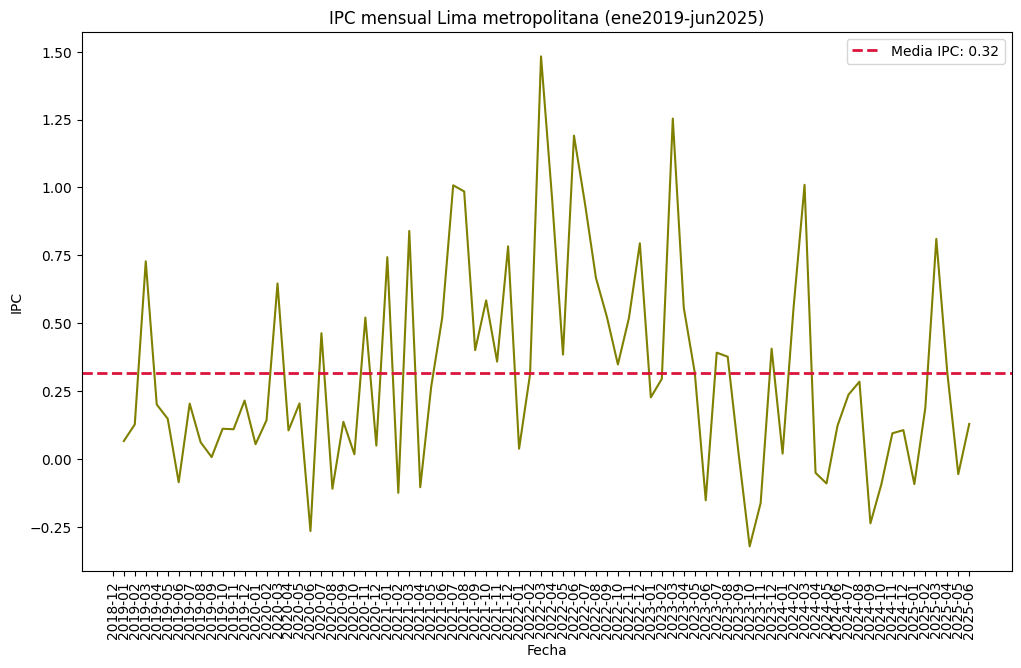

In [37]:
#hago grafico de lineas para observar estacionariedad en "IPC"

media_ipc = df['IPC'].mean()
plt.figure(figsize=(12,7))
sns.lineplot(y= "IPC", x = "Fecha", data = df, color = "olive")
plt.title("IPC mensual Lima metropolitana (ene2019-jun2025)")
plt.ylabel("IPC")
plt.xlabel("Fecha")
plt.xticks(rotation=90)
plt.axhline(y=media_ipc, color="crimson", linestyle="--", linewidth=2, label=f"Media IPC: {media_ipc:.2f}")
plt.legend()
plt.show()

In [46]:
#ahora testeamos si ipc es estacionaria, para llevar adelante el modelo arma o arima requerimos que la variable sea estacionaria
from statsmodels.tsa.stattools import adfuller

# Aplica test ADF a la columna IPC
resultado_adf = adfuller(df["IPC"].dropna())

# Imprime resultados
print("ADF Statistic:", resultado_adf[0])
print("p-value:", resultado_adf[1])

ADF Statistic: -2.292937791217775
p-value: 0.17425579198644786


In [47]:
#Aplico diferenciacion sobre la variable ipc
df["IPC_diff"] = df["IPC"].diff()

# Aplica test ADF a la columna IPC
resultado_adf = adfuller(df["IPC_diff"].dropna())

# Imprime resultados
print("ADF Statistic:", resultado_adf[0])
print("p-value:", resultado_adf[1])

ADF Statistic: -1.9785004406384286
p-value: 0.2960787309942677


In [51]:
df["IPC_diff2"] = df["IPC"].diff().diff()
resultado_diff2 = adfuller(df["IPC_diff2"].dropna())
print("p-value segunda diferencia:", resultado_diff2[1])

p-value segunda diferencia: 3.4093387629077508e-09


COMO EL P-VALUE ES MENOR A 0.05 ENTONCES PODEMOS TRABAJAR CON LA SERIE DE TIEMPO DIFERENCIADA DOS VECES, DADO ESTE PASO SABEMOS QUE DESCARTAMOS EL MODELO ARMA Y TRABAJAREMOS CON UN MODELO ARIMA (p,2,q).

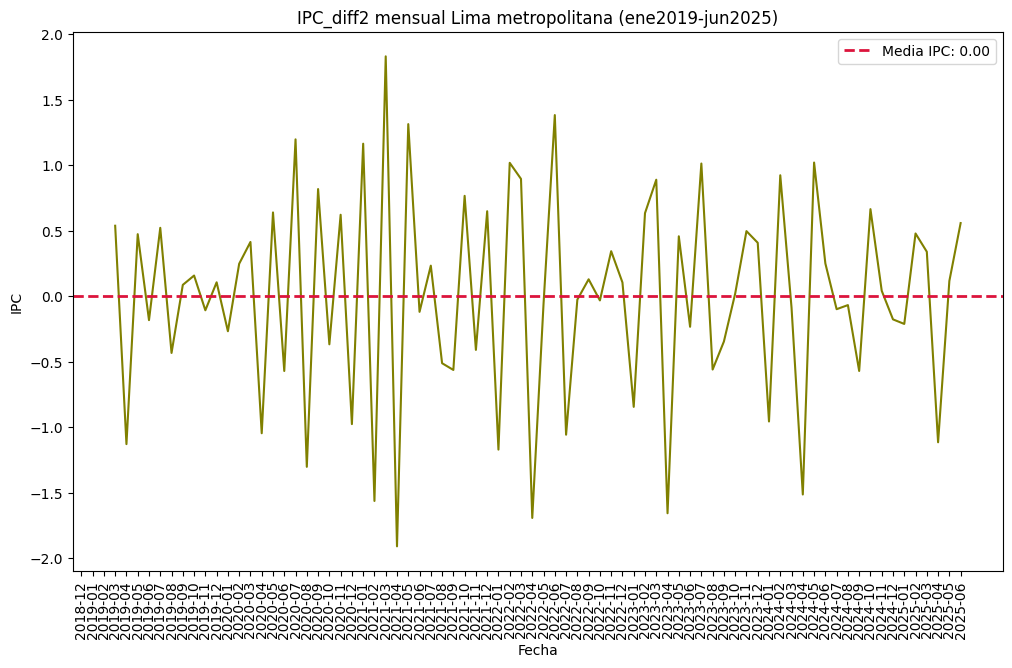

In [67]:
#hago grafico de lineas para observar estacionariedad en "IPC"

media_ipc = df['IPC_diff2'].mean()
plt.figure(figsize=(12,7))
sns.lineplot(y= "IPC_diff2", x = "Fecha", data = df, color = "olive")
plt.title("IPC_diff2 mensual Lima metropolitana (ene2019-jun2025)")
plt.ylabel("IPC")
plt.xlabel("Fecha")
plt.xticks(rotation=90)
plt.axhline(y=media_ipc, color="crimson", linestyle="--", linewidth=2, label=f"Media IPC: {media_ipc:.2f}")
plt.legend()
plt.show()

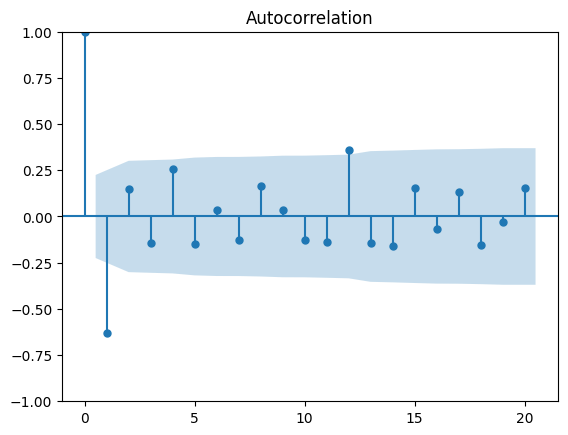

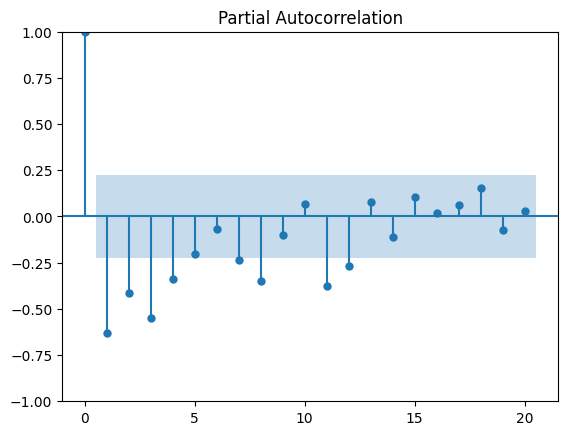

In [70]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plot_acf(df["IPC"].diff().diff().dropna(), lags=20)
plot_pacf(df["IPC"].diff().diff().dropna(), lags=20)
plt.show()

DADA LA LECTURA DE LOS GRAFICOS ACF Y PACF lo ideal es trabajar con modelos como ARIMA (1,2,1), (1,2,0), (2,2,1).

In [77]:
from statsmodels.tsa.arima.model import ARIMA

# Creo el modelo ARIMA
modelo = ARIMA(df["IPC"], order=(1, 2, 1))

# Ajusto el modelo
resultado = modelo.fit()

# Muestro la salida
print(resultado.summary())

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


                               SARIMAX Results                                
Dep. Variable:                    IPC   No. Observations:                   79
Model:                 ARIMA(1, 2, 1)   Log Likelihood                 -51.604
Date:                Tue, 15 Jul 2025   AIC                            109.208
Time:                        00:46:17   BIC                            116.239
Sample:                    12-01-2018   HQIC                           112.020
                         - 06-01-2025                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.4304      0.111     -3.893      0.000      -0.647      -0.214
ma.L1         -0.9969      1.122     -0.888      0.374      -3.197       1.203
sigma2         0.1771      0.200      0.886      0.3

In [79]:
# Creo el modelo ARIMA
model = ARIMA(df["IPC"], order=(1, 2, 0))

# Ajusto el modelo
resultado1 = model.fit()

# Muestro la salida
print(resultado1.summary())

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


                               SARIMAX Results                                
Dep. Variable:                    IPC   No. Observations:                   79
Model:                 ARIMA(1, 2, 0)   Log Likelihood                 -78.175
Date:                Tue, 15 Jul 2025   AIC                            160.350
Time:                        00:46:29   BIC                            165.038
Sample:                    12-01-2018   HQIC                           162.225
                         - 06-01-2025                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.6301      0.085     -7.385      0.000      -0.797      -0.463
sigma2         0.3783      0.065      5.807      0.000       0.251       0.506
Ljung-Box (L1) (Q):                   5.80   Jarque-

In [80]:
# Creo el modelo ARIMA
model2 = ARIMA(df["IPC"], order=(2, 2, 1))

# Ajusto el modelo
resultado2 = model2.fit()

# Muestro la salida
print(resultado2.summary())

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


                               SARIMAX Results                                
Dep. Variable:                    IPC   No. Observations:                   79
Model:                 ARIMA(2, 2, 1)   Log Likelihood                 -47.667
Date:                Tue, 15 Jul 2025   AIC                            103.334
Time:                        00:46:45   BIC                            112.709
Sample:                    12-01-2018   HQIC                           107.084
                         - 06-01-2025                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.5744      0.126     -4.564      0.000      -0.821      -0.328
ar.L2         -0.3170      0.109     -2.902      0.004      -0.531      -0.103
ma.L1         -0.9990      3.222     -0.310      0.7

In [97]:
#prediccion de IPC lima metropolitana julio 2025
#modelo arima (1,2,1)
modelo = ARIMA(df["IPC"], order=(1, 2, 1))
modelo = modelo.fit()
pred = modelo.get_forecast(steps=1)
ipc_julio = pred.predicted_mean.iloc[0]

#modelo arima (1,2,0)
model = ARIMA(df["IPC"], order=(1, 2, 0))
model = model.fit()
pred1 = model.get_forecast(steps=1)
ipc_julio1 = pred1.predicted_mean.iloc[0]

#modelo arima(2,2,1)
model2 = ARIMA(df["IPC"], order=(2, 2, 1))
model2 = model2.fit()
pred2 = model2.get_forecast(steps=3)
ipc_julio2 = pred2.predicted_mean.iloc[0]
ipc_agosto = pred2.predicted_mean.iloc[1]
ipc_septiembre = pred2.predicted_mean.iloc[2]


#resultados de inflación por modelo

print(f"IPC ARIMA (1,2,1):julio{ipc_julio:.2f}")
print(f"IPC ARIMA (1,2,0):julio{ipc_julio1:.2f}")
print(f"IPC ARIMA (2,2,1):julio{ipc_julio2:.2f}")
print(f"IPC ARIMA (2,2,1): agosto {ipc_agosto:.2f}")
print(f"IPC ARIMA (2,2,1): septiembre {ipc_septiembre:.2f}")

IPC ARIMA (1,2,1):julio0.05
IPC ARIMA (1,2,0):julio-0.04
IPC ARIMA (2,2,1):julio0.14
IPC ARIMA (2,2,1): agosto 0.07
IPC ARIMA (2,2,1): septiembre 0.10


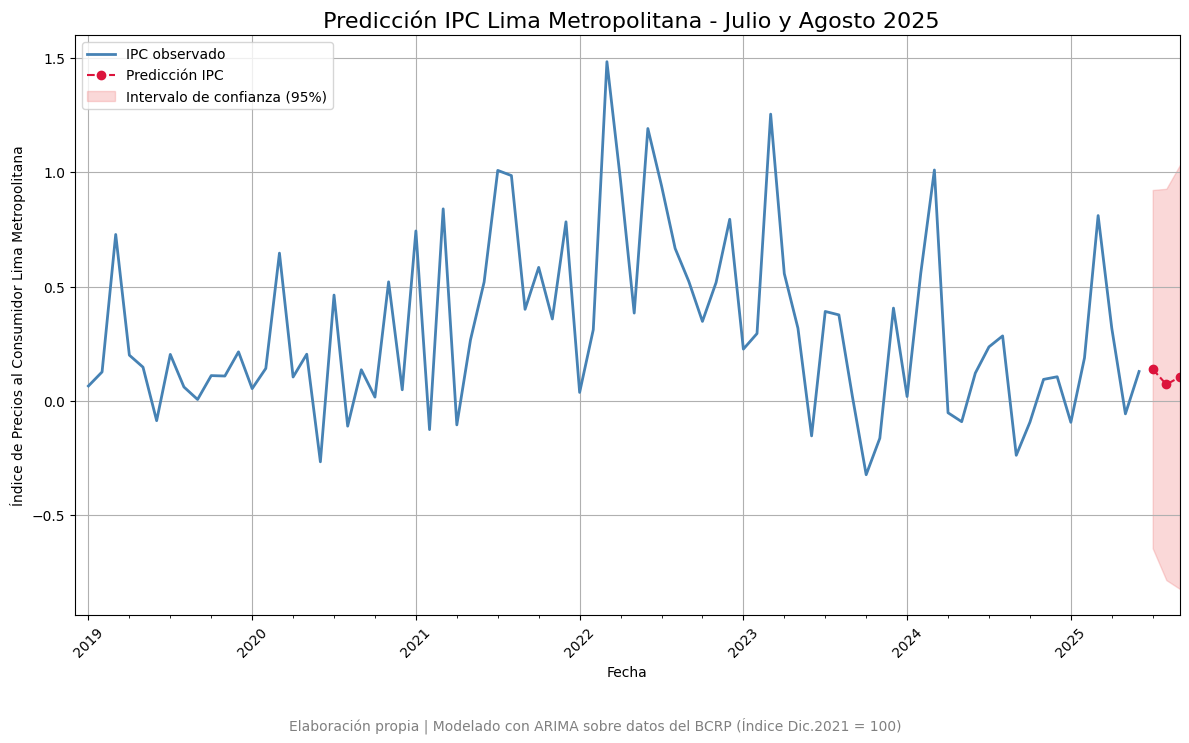

In [98]:
# ARIMA(2,2,1)
forecast = model2.get_forecast(steps=3)
pred_mean = forecast.predicted_mean
conf_int = forecast.conf_int()


plt.figure(figsize=(12,7))
df["IPC"].plot(label="IPC observado", color="steelblue", linewidth=2)

# Predicción
pred_mean.plot(style='--o', color="crimson", label="Predicción IPC")

# Banda de intervalo de confianza
plt.fill_between(conf_int.index,
                 conf_int.iloc[:, 0],
                 conf_int.iloc[:, 1],
                 color="lightcoral", alpha=0.3,
                 label="Intervalo de confianza (95%)")


plt.title(" Predicción IPC Lima Metropolitana - Julio y Agosto 2025", fontsize=16)
plt.ylabel("Índice de Precios al Consumidor Lima Metropolitana")
plt.xticks(rotation=45)
plt.grid(True)
plt.legend(loc="upper left")
plt.tight_layout()

# Pie de foto
plt.figtext(0.5, -0.05,
            "Elaboración propia | Modelado con ARIMA sobre datos del BCRP (Índice Dic.2021 = 100)",
            ha="center", fontsize=10, color="gray")

plt.show()